# Pre load

## imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sktime.classification.kernel_based import RocketClassifier
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sktime.transformations.panel.rocket import MultiRocketMultivariate
from sktime.transformations.panel.rocket import MultiRocket
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sktime.classification.deep_learning import InceptionTimeClassifier
from sktime.classification.hybrid import HIVECOTEV2
from sktime.classification.compose import ColumnEnsembleClassifier
from sklearn import preprocessing
import torch.nn as nn
from sktime.regression.kernel_based import RocketRegressor
from sktime.regression.compose import ComposableTimeSeriesForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve,roc_auc_score
import sys
from sklearn import preprocessing
from torch.utils.data import TensorDataset, DataLoader
from scipy import stats, signal
import scipy.interpolate as interp
import joblib
import torch
from torch import nn
from torch.optim import LBFGS

## User functions

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def plot_history(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()
    
def histogram(y_test,y_pred):
    plt.figure(figsize=(12,6))
    plt.hist([y_pred[y_test==0],
              y_pred[y_test==1]],
            bins=20,
            color = ['#82E0AA','#EC7063'],stacked=True)
    plt.title("Results",size=20)
    plt.grid()
    plt.show()
    
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]
    
def confusion_matrix(target, predicted, perc=False):

    data = {'y_Actual':    target,
            'y_Predicted': predicted
            }
    df = pd.DataFrame(data, columns=['y_Predicted','y_Actual'])
    confusion_matrix = pd.crosstab(df['y_Predicted'], df['y_Actual'], rownames=['Predicted'], colnames=['Actual'])
    
    if perc:
        sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')
    else:
        sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.show()

In [81]:
def best_indices(coef, x=2000):
    # Create a boolean array of coefficients that are greater than or equal to 0.002
    # assume coef is a 1D numpy array
  # keep the top 10 coefficients
    abs_coef = np.abs(coef)

    sorted_indices = np.argsort(abs_coef)  # indices of the x largest coefficients
    #top_x_indices = top_x_indices.iloc[0,-x:]
    topx=[]
    for i in np.arange(0,sorted_indices.shape[0]):
        top_x_indices = sorted_indices.reshape(-1)
        top_x_indices = top_x_indices[-x:]
        topx.append(top_x_indices)
    top_x_indices = np.concatenate(topx)
    top_x_indices.sort()
    top_x_indices = np.unique(top_x_indices)
    return top_x_indices

def calculate_points_simple(predictions, label,speed, uncertainty_if_unkown=True):
    points = 0
    factor = 1
    for i,prediction in enumerate(predictions):
        diff = abs(np.round(prediction)-np.array(label)[i])
        if uncertainty_if_unkown==True and np.array(speed)[i] in [1500,1800,2400]:
            factor = 0.2
        else:
            factor = 1
        points = points + factor*(1-diff*0.5)
    return np.round(points,1)
from collections import Counter
def aggregate_predictions(index, y_pred, label, speed):    
    columns_dict = {i: [] for i in range(11)}

    current_index = None
    row_values = [0] * 11
    counter = 0
    indices=[]
    # Iterate over the index and y_pred arrays
    for idx, pred in zip(index, y_pred):

        # Check if the index has changed
        if idx != current_index:
            indices.append(counter)
            # Add the row values to the respective columns in the dictionary
            for i, value in enumerate(row_values):
                columns_dict[i].append(value)
            
            # Reset the row values
            row_values = [0] * 11
            current_index = idx
        
        # Increment the column based on the value of y_pred
        if pred == 0:
            row_values[0] += 1
        elif pred > 0:
            column_index = int(np.round(min(pred, 10)))
            row_values[column_index] += 1
        else:
            row_values[0] += 1
        counter +=1
    # Add the last row values to the respective columns in the dictionary
    for i, value in enumerate(row_values):
        columns_dict[i].append(value)
    #unique_index, indices = np.unique(index, return_index=True)
    label_aggregated = label[indices]
    speed_aggregated = speed[indices]
    # Create the dataframe from the dictionary
    df = pd.DataFrame(columns_dict)
    df = df.drop(0)
    df = df.div(df.sum(axis=1), axis=0).round(1)

    return np.array(df), label_aggregated, speed_aggregated, indices
def calculate_points_aggregation(predictions, label, speed, index,std=1.2, uncertainty_if_unkown=True, uncertain_if_negative = True, uncertain_std_threshold = True, uncertain_value_threshold = False, aggregation = None):
    factor_check=0
    points = 0
    prediction_probabilities, label_aggregated, speed_aggregated, indices = aggregate_predictions(index, predictions, label, speed)

    if aggregation == "mean":
        result = []

        for row in prediction_probabilities:
            factor = 1
            row_result = []
            for col_index, col_value in enumerate(row):
                column = [col_index] * int(col_value*10)
                row_result.extend(column)
            result.append(row_result)
        averages = [int(np.round(sum(row) / len(row))) if row else 0 for row in result] 

        points = calculate_points_simple(averages, label_aggregated, speed_aggregated, uncertainty_if_unkown=uncertainty_if_unkown)   

    elif aggregation == "mode":
        result = []

        for row in prediction_probabilities:
            factor = 1
            row_result = []
            for col_index, col_value in enumerate(row):
                column = [col_index] * int(col_value*10)
                row_result.extend(column)
            result.append(row_result)
        most_occuring = [Counter(row).most_common(1)[0][0] if row else None for row in result]
        points = calculate_points_simple(most_occuring, label_aggregated, speed_aggregated, uncertainty_if_unkown=uncertainty_if_unkown)  
    else:
        for i,pred_proba in enumerate(prediction_probabilities):
            factor = 1
            factor_check=0
            points_case= 0
            if uncertainty_if_unkown==True and np.array(speed_aggregated)[i] in [1500,1800,2400]:
                factor = 0.2
            if i == len(prediction_probabilities) - 1:
                if np.std(predictions[indices[i]:])>std and uncertain_std_threshold == True:
                    factor = 0.2
            elif np.std(predictions[indices[i]:indices[i+1]])>std and uncertain_std_threshold == True:
                factor = 0.2   
            if uncertain_if_negative == True:    
                for pseudo_label in [0,1,2,3,4,5,6,7,8,9,10]:
                    points_case= 0
                    for k, prediction in enumerate(pred_proba):
                        diff = abs(k-pseudo_label)

                        points_case = points_case + prediction*(1-diff*0.5)
                    if points_case>0:
                        factor_check=1
                        break
                if factor_check == 0:
                    factor = 0.2
                points_case= 0   
            for j, prediction in enumerate(pred_proba):
                diff = abs(j-np.array(label_aggregated)[i])

                points_case = points_case + prediction*(1-diff*0.5)
            points = points + factor*points_case  
    return np.round(points,2)

In [4]:
from sklearn.model_selection import KFold
def select_best_features(df, label, num_features=2000):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    true_y = []
    predicted_y = []
    predicted_y2 = []
    for train_ix, test_ix in kfold.split(df):
        # select rows
        multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)))])
        train_X, test_X = df[train_ix], df[test_ix]
        train_y, test_y = label[train_ix], label[test_ix]
        multivar_rocket.fit(train_X, train_y)
        y_pred2 = multivar_rocket.predict(test_X)
        ridge_classifier = multivar_rocket.named_steps['clf']
        coefficients = ridge_classifier.coef_
        bes_indices = best_indices(coefficients,num_features)
        abs_coef = np.abs(coefficients)
        bool_coef = np.zeros(abs_coef.shape, dtype=bool)[0]
        bool_coef = bool_coef.reshape(-1)  # initialize boolean array
        bool_coef[bes_indices] = True
        df_filtered = train_X[:, bool_coef]
        multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
            ('clf', RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)))])
        multivar_rocket.fit(df_filtered, train_y)
        y_pred = multivar_rocket.predict(test_X)
        predicted_y.append(y_pred)
        predicted_y2.append(y_pred2)
        true_y.append(test_y)
    predicted_y = np.concatenate(predicted_y)  
    predicted_y2 = np.concatenate(predicted_y2)    
    true_y = np.concatenate(true_y)    
    return np.array(true_y), np.array(predicted_y), np.array(predicted_y2)

# Load data

## Load multi split minirocket 1024

In [99]:
data_path = f"C:\PHM_2023_Datadump/multi/Minirocket_1024_split"
dataframes=[]
for file_name in os.listdir(data_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_path, file_name)
        
        with open(file_path, "r") as file:
            content = file.read()
        
        df = pd.read_csv(file_path)
        dataframes.append(df)
df = np.concatenate(dataframes)
df = pd.DataFrame(df)
label = df[9998]
speed = df[9996]
torque = df[9997]
index = df[9999]
df.drop(columns=[9996, 9997, 9998, 9999], inplace=True)
data_path = f"C:\PHM_2023_Datadump/multi/train_additional_split"
dataframes=[]
for file_name in os.listdir(data_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_path, file_name)
        
        with open(file_path, "r") as file:
            content = file.read()
        
        df_tmp = pd.read_csv(file_path)
        dataframes.append(df_tmp)
df_add = np.concatenate(dataframes)
df_all = np.concatenate([df, df_add],axis=1)

138.0
137.5
127.7
138.1
134.9
127.7
251.0
237.5
234.21
240.41
239.13
236.05


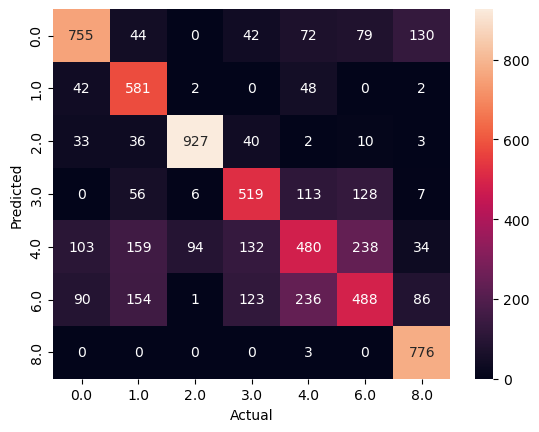

In [112]:
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                ('clf',  RidgeCV())])
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df_all, label, cv=cv)
points_average = calculate_points_aggregation(np.round(y_pred), label, speed, index, aggregation = "mean")
     
points_mode = calculate_points_aggregation(np.round(y_pred), label, speed, index, aggregation = "mode")

points_std_off = calculate_points_aggregation(np.round(y_pred), label, speed, index, uncertain_std_threshold = False)
 
points_1_2 = calculate_points_aggregation(np.round(y_pred), label, speed, index, std = 1.2)
 
points_1_5 = calculate_points_aggregation(np.round(y_pred), label, speed, index, std=1.5)
   
points_2 = calculate_points_aggregation(np.round(y_pred), label, speed, index,std = 2)
print(points_average)
print(points_mode)
print(points_std_off)
print(points_1_2)
print(points_1_5)
print(points_2)
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                ('clf',  RidgeCV())])
multivar_rocket.fit(df_all, label)
joblib.dump(multivar_rocket, f'C:/PHM_2023_Datadump/model/solo_split/all_speeds.joblib')
ridge_classifier = multivar_rocket.named_steps['clf']
coefficients = ridge_classifier.coef_
best_indices_arr = best_indices(coefficients,5000)
abs_coef = np.abs(coefficients)
bool_coef = np.zeros(abs_coef.shape, dtype=bool)
bool_coef = bool_coef.reshape(-1)  # initialize boolean array


bool_coef[best_indices_arr] = True
joblib.dump(bool_coef, f'C:/PHM_2023_Datadump/model/solo_split/all_speeds_bool_coef.joblib')
df_filtered = df_all[:, bool_coef]
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                ('clf',  RidgeCV())])
multivar_rocket.fit(df_filtered, label)
joblib.dump(multivar_rocket, f'C:/PHM_2023_Datadump/model/solo_split/all_speeds_filtered.joblib')
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                ('clf',  RidgeClassifierCV())])
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df_filtered, label, cv=cv)
points_average = calculate_points_aggregation(np.round(y_pred), label, speed, index, aggregation = "mean")
     
points_mode = calculate_points_aggregation(np.round(y_pred), label, speed, index, aggregation = "mode")

points_std_off = calculate_points_aggregation(np.round(y_pred), label, speed, index, uncertain_std_threshold = False)
 
points_1_2 = calculate_points_aggregation(np.round(y_pred), label, speed, index, std = 1.2)
 
points_1_5 = calculate_points_aggregation(np.round(y_pred), label, speed, index, std=1.5)
   
points_2 = calculate_points_aggregation(np.round(y_pred), label, speed, index,std = 2)
print(points_average)
print(points_mode)
print(points_std_off)
print(points_1_2)
print(points_1_5)
print(points_2)
confusion_mat = confusion_matrix(label, np.round(y_pred))

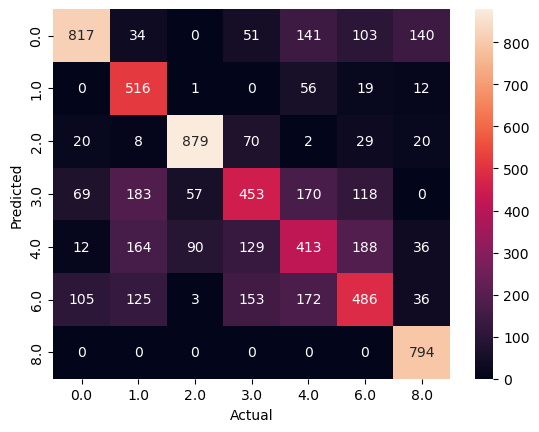

In [95]:
confusion_mat = confusion_matrix(label, np.round(y_pred))

In [93]:
best_indices_arr = best_indices(coefficients,2000)
abs_coef = np.abs(coefficients)
bool_coef = np.zeros(abs_coef.shape, dtype=bool)[0]
bool_coef = bool_coef.reshape(-1)  # initialize boolean array


bool_coef[best_indices_arr] = True
df_filtered = df_all[:, bool_coef]
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                ('clf',  RidgeClassifierCV())])
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df_filtered, label, cv=cv)
points_average = calculate_points_aggregation(np.round(y_pred), label, speed, index, aggregation = "mean")
     
points_mode = calculate_points_aggregation(np.round(y_pred), label, speed, index, aggregation = "mode")

points_std_off = calculate_points_aggregation(np.round(y_pred), label, speed, index, uncertain_std_threshold = False)
 
points_1_2 = calculate_points_aggregation(np.round(y_pred), label, speed, index, std = 1.2)
 
points_1_5 = calculate_points_aggregation(np.round(y_pred), label, speed, index, std = 1.5)
   
points_2 = calculate_points_aggregation(np.round(y_pred), label, speed, index,std = 2)
print(points_average)
print(points_mode)
print(points_std_off)
print(points_1_2)
print(points_1_5)
print(points_2)

8.5
11.0
9.7
10.9
9.54
10.5


In [ ]:
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                ('clf',  RidgeClassifierCV())])
multivar_rocket.fit(df_all, label)
best_indices_arr = best_indices(coefficients,5000)
abs_coef = np.abs(coefficients)
bool_coef = np.zeros(abs_coef.shape, dtype=bool)[0]
bool_coef = bool_coef.reshape(-1)  # initialize boolean array


bool_coef[best_indices_arr] = True
df_filtered = df_all[:, bool_coef]
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                ('clf',  RidgeClassifierCV())])
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df_filtered, label, cv=cv)
points_average = calculate_points_aggregation(np.round(y_pred), label, speed, index, aggregation = "mean")
     
points_mode = calculate_points_aggregation(np.round(y_pred), label, speed, index, aggregation = "mode")

points_std_off = calculate_points_aggregation(np.round(y_pred), label, speed, index, uncertain_std_threshold = False)
 
points_1_2 = calculate_points_aggregation(np.round(y_pred), label, speed, index, std = 1.2)
 
points_1_5 = calculate_points_aggregation(np.round(y_pred), label, speed, index, std=1.5)
   
points_2 = calculate_points_aggregation(np.round(y_pred), label, speed, index,std = 2)
print(points_average)
print(points_mode)
print(points_std_off)
print(points_1_2)
print(points_1_5)
print(points_2)

## Load solo split minirocket 1024

In [13]:
def load_solo_split_minirocket_1024(binder, seperate):    
    data_path = f"C:\PHM_2023_Datadump/solo/Minirocket_1024_split/{binder}"
    dataframes=[]
    for file_name in os.listdir(data_path):
        if file_name.endswith(".csv"):
            
            file_path = os.path.join(data_path, file_name)
            with open(file_path, "r") as file:
                content = file.read()
            
            df = pd.read_csv(file_path)
            dataframes.append(df)
    df = np.concatenate(dataframes)
    df = pd.DataFrame(df)
    label = df[9998]
    speed = df[9996]
    torque = df[9997]
    index = df[9999]
    df.drop(columns=[9996, 9997, 9998, 9999], inplace=True)
    data_path = f"C:\PHM_2023_Datadump/solo/train_additional_split/{binder}"
    dataframes=[]
    for file_name in os.listdir(data_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(data_path, file_name)
            
            with open(file_path, "r") as file:
                content = file.read()
            
            df_tmp = pd.read_csv(file_path)
            dataframes.append(df_tmp)
    df_add = np.concatenate(dataframes)
    if seperate == False: 
        df_all = np.concatenate([df_add, df],axis=1)
        return df_all, label, speed, torque, index
    else:
        return df, df_add, label, speed, torque, index

## Load solo minirocket 1024

In [12]:
def load_solo_minirocket_1024(binder, seperate=True):   
    data_path = f"C:/PHM_2023_Datadump/solo/Minirocket_1024/{binder}"
    dataframes=[]
    for file_name in os.listdir(data_path):

        if file_name.endswith(".csv"):
            file_path = os.path.join(data_path, file_name)
            
            with open(file_path, "r") as file:
                content = file.read()
            
            df = pd.read_csv(file_path)
            dataframes.append(df)
    
    df = np.concatenate(dataframes)
    df = pd.DataFrame(df)
    label = df[9998]
    speed = df[9996]
    torque = df[9997]
    df.drop(columns=[9996, 9998], inplace=True)
    
    data_path = f"C:/PHM_2023_Datadump/solo/train_additional/{binder}"
    dataframes=[]
    for file_name in os.listdir(data_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(data_path, file_name)
            
            with open(file_path, "r") as file:
                content = file.read()
            
            df_tmp = pd.read_csv(file_path)
            dataframes.append(df_tmp)
    df_add = np.concatenate(dataframes)
    if seperate == False: 
        df_all = np.concatenate([df, df_add],axis=1)
        return df_all, label, speed, torque
    else:
        return df, df_add, label, speed, torque

In [134]:
def load_test_solo_minirocket_1024(name, seperate=True):   
    data_path = f"C:/PHM_2023_Datadump/test_data/solo/Minirocket_1024/"
    dataframes=[]
    for file_name in os.listdir(data_path):

        if file_name.startswith(f"{name}") and file_name.endswith(".csv"):
            file_path = os.path.join(data_path, file_name)
            
            with open(file_path, "r") as file:
                content = file.read()
            
            df = pd.read_csv(file_path)
            dataframes.append(df)
    
    df = np.concatenate(dataframes)
    df = pd.DataFrame(df)
    speed = df[9996]
    torque = df[9997]
    df.drop(columns=[9996, 9997], inplace=True)
    
    data_path = f"C:/PHM_2023_Datadump/test_data/solo/test_additional"
    dataframes=[]
    for file_name in os.listdir(data_path):
        if file_name.startswith(f"{name}") and file_name.endswith(".csv"):
            file_path = os.path.join(data_path, file_name)
            
            with open(file_path, "r") as file:
                content = file.read()
            
            df_tmp = pd.read_csv(file_path)
            dataframes.append(df_tmp)
    df_add = np.concatenate(dataframes)
    if seperate == False: 
        df_all = np.concatenate([df, df_add],axis=1)
        return df_all, label, speed, torque
    else:
        return df, df_add, label, speed, torque

# Implementation of ANN

## regression with limit

In [98]:
class Lin_limited(nn.Module):
    def __init__(self, input_size_rocket, input_size_stats):
        super(Lin_limited, self).__init__()

        self.linear1 = nn.Linear(input_size_stats + input_size_rocket, 1)


    def forward(self, x):
        
        output = self.linear1(x)
        #output = torch.clamp(output, min=0, max=10)
        return output
    
def train(model, optimizer, loss_function, inputs, targets, num_epochs):
    def closure():
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = loss_function(predictions, targets)
        loss.backward()
        return loss

    
    for epoch in range(num_epochs):
        optimizer.step(closure)
        loss = closure()
        print(f"Epoch {epoch}, Loss: {loss.item()}")

## regression with limit ann for stats

In [142]:
class Lin_statsNN_limited(nn.Module):
    def __init__(self, input_size_rocket, input_size_stats):
        super(Lin_statsNN_limited, self).__init__()
        self.linear1 = nn.Linear(input_size_stats, 2*input_size_stats)
        self.linear2 = nn.Linear(2*input_size_stats, input_size_stats)
        self.linear3 = nn.Linear(input_size_stats + input_size_rocket, 1)
        self.relu = nn.ReLU()

    def forward(self, x, speed, torque):
        x1 = self.relu(self.linear1(x))
        x2 = self.relu(self.linear2(x1))     
        #x = torch.cat((x2, x_rocket), dim=1)
        output = self.linear3(x)

        return output
    
def train(model, optimizer, loss_function, inputs, targets, num_epochs):
    def closure():
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = loss_function(predictions, targets)
        loss.backward()
        return loss

    
    for epoch in range(num_epochs):
        optimizer.step(closure)
        loss = closure()
        print(f"Epoch {epoch}, Loss: {loss.item()}")

## regression with limit ann for all

## regression with limit ann for all bayesian

# Experment with solo minirocket1024

In [37]:
df_all, label, speed, torque = load_solo_minirocket_1024("V3600_", seperate=False)
nan_columns = np.isnan(df_all).any(axis=0)

# Remove columns with NaN values
df_all = df_all[:, ~nan_columns]
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', LinearRegression())])

In [38]:
df, df_add, label, speed, torque = load_solo_minirocket_1024("V3600_", seperate=True)
nan_columns = np.isnan(df_add).any(axis=0)

# Remove columns with NaN values
df_add = df_add[:, ~nan_columns]

multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', LinearRegression())])

In [9]:
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)))])

## linear regression only rocket

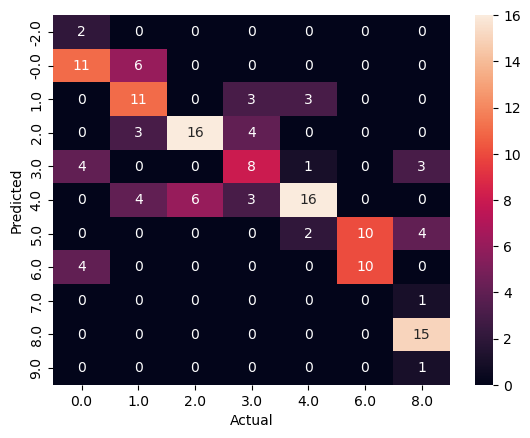

In [179]:
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df, label, cv=cv)
# Step 7: Compute the confusion matrix
confusion_mat = confusion_matrix(label, np.round(y_pred))


In [180]:
points = calculate_points_simple(np.round(y_pred), label, speed)
points

82.5

## Linear regression only stats

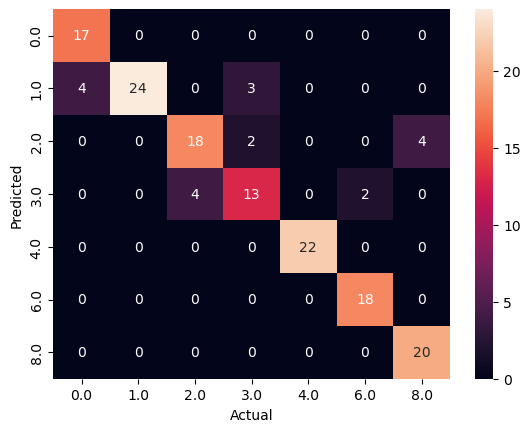

In [232]:

cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df_add, label, cv=cv)
# Step 7: Compute the confusion matrix
confusion_mat = confusion_matrix(label, np.round(y_pred))


In [229]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_ix, test_ix in kfold.split(df_add):
    # select rows
    multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                ('clf', RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)))])
    train_X, test_X = df_add[train_ix], df_add[test_ix]
    train_y, test_y = label[train_ix], label[test_ix]
    print(train_X.shape)
    print(train_y.shape)
    multivar_rocket.fit(train_X, train_y)
    y_pred2 = multivar_rocket.predict(test_X)

(120, 610)
(120,)
(121, 610)
(121,)
(121, 610)
(121,)
(121, 610)
(121,)
(121, 610)
(121,)


In [178]:
points = calculate_points_simple(np.round(y_pred), label, speed)
points

123.5

In [39]:
multivar_rocket.fit(df_add, label)

Pipeline(steps=[('scl', StandardScaler(with_mean=False)),
                ('clf', LinearRegression())])

In [40]:
ridge_classifier = multivar_rocket.named_steps['clf']
coefficients = ridge_classifier.coef_
bes_indices = best_indices(coefficients,20)

In [41]:
bes_indices

array([  7,   8,  25,  29, 111, 127, 192, 193, 211, 214, 237, 238, 251,
       273, 274, 275, 276, 277, 396, 409], dtype=int64)

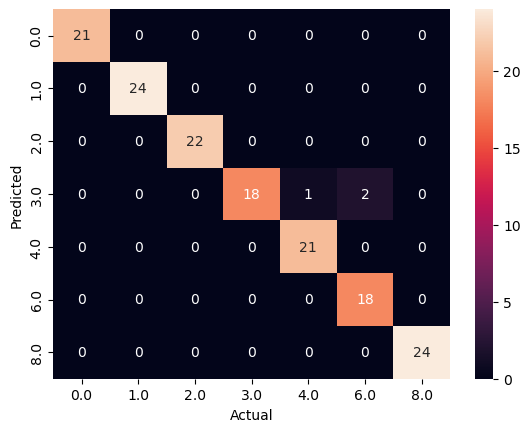

In [230]:
confusion_mat = confusion_matrix(label_mixed, pred2)

(151,)


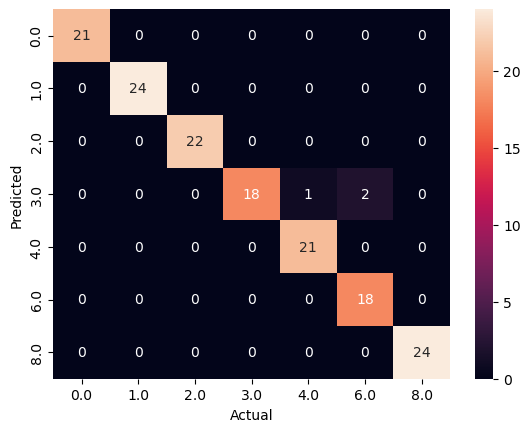

In [218]:
label_mixed, pred , pred2= select_best_features(df_add, label)
print(pred.shape)
confusion_mat = confusion_matrix(label_mixed, pred)

In [201]:
points = calculate_points_simple(pred, label_mixed, speed)
points

147.5

## Linear regression combined

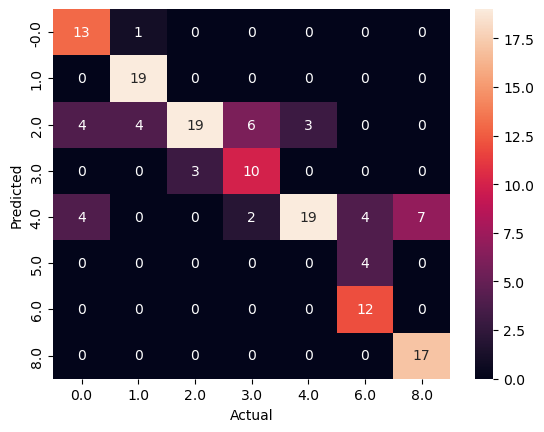

In [173]:
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df_all, label, cv=cv)
# Step 7: Compute the confusion matrix
confusion_mat = confusion_matrix(label, np.round(y_pred))

In [174]:
points = calculate_points_simple(np.round(y_pred), label, speed)
points

108.0

## Lin limited

In [132]:
loss_function = nn.MSELoss()
model = Lin_limited(input_size_rocket = 9997, input_size_stats= 610)
optimizer = LBFGS(model.parameters(), lr=0.1)

In [139]:
scaler = StandardScaler(with_mean=False)
df_all_scaled = scaler.fit_transform(df_all)
df_all_torch = torch.tensor(df_all_scaled, dtype=torch.float32)
label_torch = np.array(label).reshape(-1,1)
label_torch = torch.tensor(label_torch, dtype=torch.float32)

In [166]:
from sklearn.model_selection import KFold
import torch.optim as optim
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
true_y = []
predicted_y = []
for train_ix, test_ix in kfold.split(df_all_torch):
 # select rows
    loss_function = nn.MSELoss()
    model = Lin_limited(input_size_rocket = 9997, input_size_stats= 610)
    optimizer = LBFGS(model.parameters(), lr=1)
    train_X, test_X = df_all_torch[train_ix], df_all_torch[test_ix]
    train_y, test_y = label_torch[train_ix], label_torch[test_ix]

    train(model, optimizer, loss_function, train_X, train_y, num_epochs=1000)
    y_pred = model.forward(test_X)
    predicted_y.append(y_pred)
    true_y.append(test_y)
numpy_arrays = [tensor.detach().numpy() for tensor in predicted_y]
predicted_y = np.concatenate(numpy_arrays) 
numpy_arrays = [tensor.detach().numpy() for tensor in true_y]
true_y = np.concatenate(numpy_arrays) 
predicted_y = predicted_y.reshape(-1)
true_y = true_y.reshape(-1)

Epoch 0, Loss: 7.239762783050537
Epoch 1, Loss: 7.239748001098633
Epoch 2, Loss: 5.193153381347656
Epoch 3, Loss: 3.258934259414673
Epoch 4, Loss: 2.373573064804077
Epoch 5, Loss: 1.3797329664230347
Epoch 6, Loss: 0.6396996378898621
Epoch 7, Loss: 0.3134726285934448
Epoch 8, Loss: 0.16363975405693054
Epoch 9, Loss: 0.16225168108940125
Epoch 10, Loss: 0.11897560209035873
Epoch 11, Loss: 0.06291989982128143
Epoch 12, Loss: 0.061517976224422455
Epoch 13, Loss: 0.061554159969091415
Epoch 14, Loss: 0.043408866971731186
Epoch 15, Loss: 0.03923426568508148
Epoch 16, Loss: 0.03899543732404709
Epoch 17, Loss: 0.02789570949971676
Epoch 18, Loss: 0.027893124148249626
Epoch 19, Loss: 0.023640397936105728
Epoch 20, Loss: 0.01769314892590046
Epoch 21, Loss: 0.017708778381347656
Epoch 22, Loss: 0.017665188759565353
Epoch 23, Loss: 0.011571526527404785
Epoch 24, Loss: 0.009424608200788498
Epoch 25, Loss: 0.009417484514415264
Epoch 26, Loss: 0.009425024501979351
Epoch 27, Loss: 0.009423173032701015
Epo

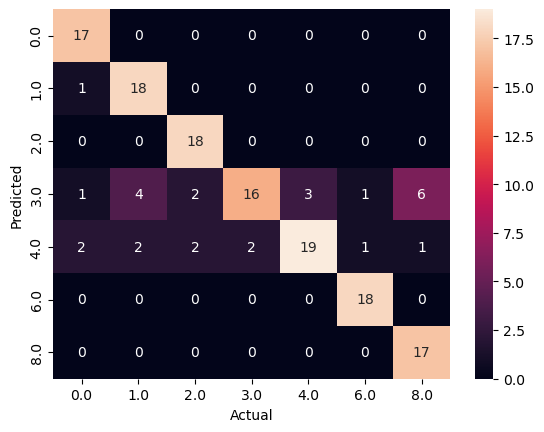

In [167]:
confusion_mat = confusion_matrix(true_y,  np.round(predicted_y))

In [172]:
points = calculate_points_simple(np.round(predicted_y), true_y, speed)
points

113.0

## Lin with ANN for stats

In [20]:
loss_function = nn.MSELoss()
model = Lin_statsNN_limited(input_size_rocket = 9997, input_size_stats= 610)
optimizer = LBFGS(model.parameters(), lr=0.001)

In [21]:
scaler = StandardScaler(with_mean=False)
df_all = scaler.fit_transform(df_all)
df_all = torch.tensor(df_all, dtype=torch.float32)
label = torch.tensor(label, dtype=torch.float32)

C:\Users\janni\AppData\Local\Temp\ipykernel_15756\2820213115.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32)


In [23]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
true_y = []
predicted_y = []
for train_ix, test_ix in kfold.split(df_all):
 # select rows
 train_X, test_X = df_all[train_ix], df_all[test_ix]
 train_y, test_y = label[train_ix], label[test_ix]

 train(model, optimizer, loss_function, train_X, train_y, num_epochs=10)
 y_pred = model.forward(test_X)
 predicted_y.append(y_pred)
 true_y.append(test_y)



c:\Users\janni\anaconda3\envs\python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([120])) that is different to the input size (torch.Size([120, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\janni\anaconda3\envs\python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([121])) that is different to the input size (torch.Size([121, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 20.350000381469727
Epoch 1, Loss: 20.350000381469727
Epoch 2, Loss: 20.350000381469727
Epoch 3, Loss: 20.350000381469727
Epoch 4, Loss: 20.350000381469727
Epoch 5, Loss: 20.350000381469727
Epoch 6, Loss: 20.350000381469727
Epoch 7, Loss: 20.350000381469727
Epoch 8, Loss: 20.350000381469727
Epoch 9, Loss: 20.350000381469727
Epoch 0, Loss: 18.330577850341797
Epoch 1, Loss: 18.330577850341797
Epoch 2, Loss: 18.330577850341797
Epoch 3, Loss: 18.330577850341797
Epoch 4, Loss: 18.330577850341797
Epoch 5, Loss: 18.330577850341797
Epoch 6, Loss: 18.330577850341797
Epoch 7, Loss: 18.330577850341797
Epoch 8, Loss: 18.330577850341797
Epoch 9, Loss: 18.330577850341797
Epoch 0, Loss: 18.991735458374023
Epoch 1, Loss: 18.991735458374023
Epoch 2, Loss: 18.991735458374023
Epoch 3, Loss: 18.991735458374023
Epoch 4, Loss: 18.991735458374023
Epoch 5, Loss: 18.991735458374023
Epoch 6, Loss: 18.991735458374023
Epoch 7, Loss: 18.991735458374023
Epoch 8, Loss: 18.991735458374023
Epoch 9, Loss:

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform stratified cross-validation using cross_val_score
scores = cross_val_score(multivar_rocket, X, y, cv=kfold)

In [ ]:
train(model, optimizer, loss_function, df, df_add, label, num_epochs=1000)

# Quick_Training

## only rocket

In [71]:
points_only_rocket= []
for d in ["V100_", "V200_","V300_","V400_","V500_","V600_","V700_","V800_","V900_","V1000_","V1200_","V2100_","V2700_","V3000_","V3600_"]:
    df, df_add, label, speed, torque = load_solo_minirocket_1024(d, seperate=True)
    nan_columns = np.isnan(df_add).any(axis=0)
    df_add = df_add[:, ~nan_columns]

    multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', LinearRegression())])
    cv = StratifiedKFold(n_splits=5)
    y_pred = cross_val_predict(multivar_rocket, df, label, cv=cv)
    #confusion_mat = confusion_matrix(label, np.round(y_pred))
    points = calculate_points_simple(np.round(y_pred), label, speed)
    points_only_rocket.append(points)  
    print(d)     

points_only_rocket
sum(points_only_rocket)

V100_
V200_
V300_
V400_
V500_
V600_
V700_
V800_
V900_
V1000_
V1200_
V2100_
V2700_
V3000_
V3600_


1675.0

## only stats

In [72]:
points_only_rocket= []
for d in ["V100_", "V200_","V400_","V500_","V600_","V700_","V800_","V900_","V1000_","V1200_","V2100_","V2700_","V3000_","V3600_"]:
    df, df_add, label, speed, torque = load_solo_minirocket_1024(d, seperate=True)
    nan_columns = np.isnan(df_add).any(axis=0)
    df_add = df_add[:, ~nan_columns]

    multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', LinearRegression())])
    cv = StratifiedKFold(n_splits=5)
    y_pred = cross_val_predict(multivar_rocket, df_add, label, cv=cv)
    points = calculate_points_simple(np.round(y_pred), label, speed)
    points_only_rocket.append(points)       

points_only_rocket
sum(points_only_rocket)

1554.0

## both

In [73]:
points_only_rocket= []
for d in ["V100_", "V200_","V400_","V500_","V600_","V700_","V800_","V900_","V1000_","V1200_","V2100_","V2700_","V3000_","V3600_"]:
    df_all, label, speed, torque = load_solo_minirocket_1024(d, seperate=False)
    nan_columns = np.isnan(df_all).any(axis=0)
    df_all = df_all[:, ~nan_columns]

    multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', LinearRegression())])
    cv = StratifiedKFold(n_splits=5)
    y_pred = cross_val_predict(multivar_rocket, df_all, label, cv=cv)
    points = calculate_points_simple(np.round(y_pred), label, speed)
    points_only_rocket.append(points)          

points_only_rocket
sum(points_only_rocket)

1644.0

## both split

## both split speed and torque separated

In [168]:
from sklearn.model_selection import train_test_split
df_all_a, label, speed, torque, index = load_solo_split_minirocket_1024("V1000_", seperate=False)

In [163]:
df_all_a.shape

(939, 10460)

In [167]:
label

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
934    8.0
935    8.0
936    8.0
937    8.0
938    8.0
Name: 9998, Length: 939, dtype: float64

In [169]:
X_train, X_test, y_train, y_test = train_test_split(df_all_a, label, test_size=0.2, random_state=42)

In [171]:
df_all, label, speed, torque = load_test_solo_minirocket_1024("data_8_", seperate=False)

In [172]:
y_pred = multivar_rocket.predict(df_all)

In [173]:
y_pred

array([-56350.9835418 , -56637.22629977, -56638.84857984, -57163.70867029,
       -56709.50071803, -57162.24220332, -57357.31270863, -56073.29809158,
       -56516.10463195, -55790.94291388, -56522.46121583])

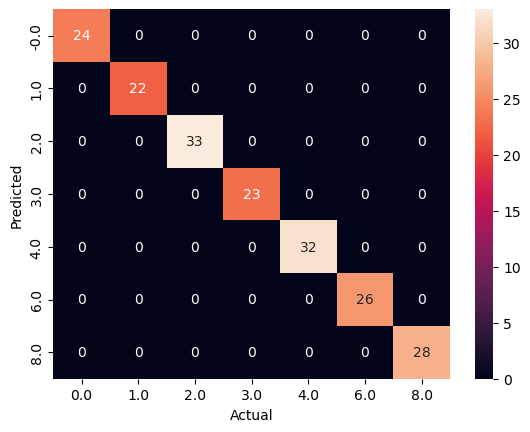

In [117]:
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                        ('clf',  RidgeCV())])
multivar_rocket.fit(X_train, y_train)
y_pred = multivar_rocket.predict(X_test)
confusion_mat = confusion_matrix(y_test, np.round(y_pred))

In [119]:
X_train.shape

(751, 10460)

In [113]:

points_average=[]
points_mode=[]
points_std_off=[]
points_1_2= []
points_1_5 =[]
points_2 = []
for d in ["V100_", "V200_","V300_","V400_","V500_","V600_","V700_","V800_","V900_","V1000_","V1200_","V2100_","V2700_","V3000_","V3600_"]:
    

    df_all, label, speed, torque, index = load_solo_split_minirocket_1024(d, seperate=False)
    directory_path = '/path/to/your/directory/'
    nan_columns = np.isnan(df_all).any(axis=0)
    df_all = df_all[:, ~nan_columns]
    unique_torque = np.unique(torque)
    # print(torque)
    for tor in unique_torque:
        multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                        ('clf', RidgeCV())])
        # print(tor)

        #print(df_all[:,0])
        df_sel = df_all[df_all[:,0]==tor]
        label_sel = label[df_all[:,0]==tor].reset_index(drop=True)
        index_sel = index[df_all[:,0]==tor].reset_index(drop=True)
        speed_sel = speed[df_all[:,0]==tor].reset_index(drop=True)
        # print(df_sel)
        # print(index_sel)
        # print(label_sel)
        # print(speed_sel)
        cv = StratifiedKFold(n_splits=5)
        y_pred = cross_val_predict(multivar_rocket, df_sel, label_sel, cv=cv)


        points = calculate_points_aggregation(np.round(y_pred), label_sel, speed_sel, index_sel, aggregation = "mean")
        points_average.append(points)       
        points = calculate_points_aggregation(np.round(y_pred), label_sel, speed_sel, index_sel, aggregation = "mode")
        points_mode.append(points)  
        points = calculate_points_aggregation(np.round(y_pred), label_sel, speed_sel, index_sel, uncertain_std_threshold = False)
        points_std_off.append(points)  
        points = calculate_points_aggregation(np.round(y_pred), label_sel, speed_sel, index_sel, std = 1.2)
        points_1_2.append(points)  
        points = calculate_points_aggregation(np.round(y_pred), label_sel, speed_sel, index_sel, std=1.5)
        points_1_5.append(points)     
        points = calculate_points_aggregation(np.round(y_pred), label_sel, speed_sel, index_sel,std = 2)
        points_2.append(points)  
        multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                        ('clf',  RidgeCV())])
        multivar_rocket.fit(df_sel, label_sel)
        joblib.dump(multivar_rocket, f'C:/PHM_2023_Datadump/model/solo_split/{d}_{tor}.joblib')
        ridge_classifier = multivar_rocket.named_steps['clf']
        coefficients = ridge_classifier.coef_
        best_indices_arr = best_indices(coefficients,2000)
        abs_coef = np.abs(coefficients)
        bool_coef = np.zeros(abs_coef.shape, dtype=bool)
        bool_coef = bool_coef.reshape(-1)  # initialize boolean array


        bool_coef[best_indices_arr] = True
        joblib.dump(bool_coef, f'C:/PHM_2023_Datadump/model/solo_split/{d}_{tor}_bool_coef.joblib')
        df_filtered = df_sel[:, bool_coef]
        multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                        ('clf',  RidgeCV())])
        multivar_rocket.fit(df_filtered, label_sel)
        joblib.dump(multivar_rocket, f'C:/PHM_2023_Datadump/model/solo_split/{d}_{tor}_filtered.joblib')

print(sum(points_average))
print(sum(points_mode))
print(sum(points_std_off))
print(sum(points_1_2))
print(sum(points_1_5))
print(sum(points_2))

1952.5
1968.0
1945.4
1945.3200000000002
1945.3200000000002
1945.3200000000002


In [78]:
points_average=[]
points_mode=[]
points_std_off=[]
points_1_2= []
points_1_5 =[]
points_2 = []
for d in ["V100_", "V200_","V300_","V400_","V500_","V600_","V700_","V800_","V900_","V1000_","V1200_","V2100_","V2700_","V3000_","V3600_"]:
    

    df_all, label, speed, torque, index = load_solo_split_minirocket_1024(d, seperate=False)

    nan_columns = np.isnan(df_all).any(axis=0)
    df_all = df_all[:, ~nan_columns]
    unique_torque = np.unique(torque)
    # print(torque)

    multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', LinearRegression())])
    # print(tor)



    # print(label_sel)
    # print(speed_sel)
    cv = StratifiedKFold(n_splits=5)
    y_pred = cross_val_predict(multivar_rocket, df_all, label, cv=cv)


    points = calculate_points_aggregation(np.round(y_pred), label, speed, index, aggregation = "mean")
    points_average.append(points)       
    points = calculate_points_aggregation(np.round(y_pred), label, speed, index, aggregation = "mode")
    points_mode.append(points)  
    points = calculate_points_aggregation(np.round(y_pred), label, speed, index, uncertain_std_threshold = False)
    points_std_off.append(points)  
    points = calculate_points_aggregation(np.round(y_pred), label, speed, index, std = 1.2)
    points_1_2.append(points)  
    points = calculate_points_aggregation(np.round(y_pred), label, speed, index, std=1.5)
    points_1_5.append(points)     
    points = calculate_points_aggregation(np.round(y_pred), label, speed, index,std = 2)
    points_2.append(points)  
        #print(f"{d},{tor}")


print(sum(points_average))
print(sum(points_mode))
print(sum(points_std_off))
print(sum(points_1_2))
print(sum(points_1_5))
print(sum(points_2))

1836.0
1832.5
1814.6499999999996
1814.8499999999997
1814.4899999999996
1814.4899999999996


In [59]:
points_only_rocket= []
for d in ["V100_", "V200_","300","V400_","V500_","V600_","V700_","V800_","V900_","V1000_","V1200_","V2100_","V2700_","V3000_","V3600_"]:
    

    df_all, label, speed, torque, index = load_solo_split_minirocket_1024(d, seperate=False)

    nan_columns = np.isnan(df_all).any(axis=0)
    df_all = df_all[:, ~nan_columns]
    unique_torque = np.unique(torque)
    # print(torque)
    for tor in unique_torque:
        multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                        ('clf', LinearRegression())])
        # print(tor)

        #print(df_all[:,0])
        df_sel = df_all[df_all[:,0]==tor]
        label_sel = label[df_all[:,0]==tor].reset_index(drop=True)
        index_sel = index[df_all[:,0]==tor].reset_index(drop=True)
        speed_sel = speed[df_all[:,0]==tor].reset_index(drop=True)
        # print(df_sel)
        # print(index_sel)
        # print(label_sel)
        # print(speed_sel)
        cv = StratifiedKFold(n_splits=5)
        y_pred = cross_val_predict(multivar_rocket, df_sel, label_sel, cv=cv)


        points = calculate_points_aggregation(np.round(y_pred), label_sel, speed_sel, index_sel, )
        points_only_rocket.append(points)          
        #print(f"{d},{tor}")

points_only_rocket
sum(points_only_rocket)

1786.72

In [ ]:
## both 

In [ ]:
df, df_add, label, speed, torque = load_solo_minirocket_1024("V1200_", seperate=True)
nan_columns = np.isnan(df_add).any(axis=0)

# Remove columns with NaN values
df_add = df_add[:, ~nan_columns]

multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', LinearRegression())])

In [ ]:
df, df_add, label, speed, torque = load_solo_minirocket_1024("V1200_", seperate=True)
nan_columns = np.isnan(df_add).any(axis=0)

# Remove columns with NaN values
df_add = df_add[:, ~nan_columns]

multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', LinearRegression())])

In [19]:
torque

0      100.0
1      100.0
2      100.0
3      100.0
4      100.0
       ...  
146    500.0
147     50.0
148     50.0
149     50.0
150     50.0
Name: 9997, Length: 151, dtype: float64

In [5]:
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', LinearRegression())])

In [12]:
multivar_rocket.fit(df_all, label)

Pipeline(steps=[('scl', StandardScaler(with_mean=False)),
                ('clf', LinearRegression())])

In [13]:
ridge_classifier = multivar_rocket.named_steps['clf']
coefficients = ridge_classifier.coef_

In [14]:
best_indices = best_indices(coefficients,2000)

In [15]:
abs_coef = np.abs(coefficients)
bool_coef = np.zeros(abs_coef.shape, dtype=bool)
bool_coef = bool_coef.reshape(-1)  # initialize boolean array


bool_coef[best_indices] = True

In [25]:
bool_coef

array([False, False,  True, ..., False, False, False])

In [23]:
df.reset_index(inplace=True, drop=True)

In [26]:
df_transformed_filtered = df.loc[:, bool_coef]

In [25]:
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df_transformed_filtered, label, cv=cv)



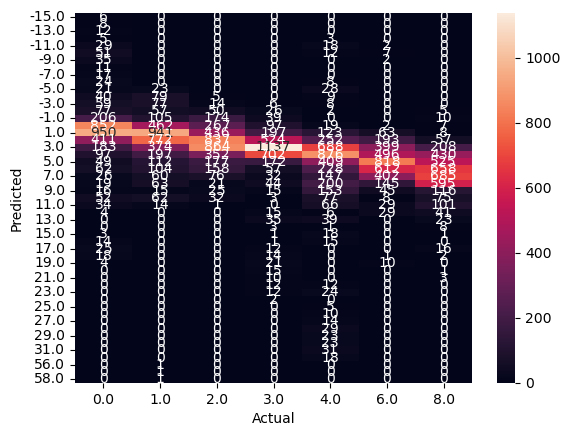

Confusion Matrix:
 None


In [33]:
# Step 7: Compute the confusion matrix
confusion_mat = confusion_matrix(label, np.round(y_pred))

# Step 8: View the confusion matrix
print("Confusion Matrix:\n", confusion_mat)

# Without split

In [ ]:
data_path = f"C:\PHM_2023_Datadump\Minirocket_1024"
dataframes=[]
for file_name in os.listdir(data_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_path, file_name)
        
        with open(file_path, "r") as file:
            content = file.read()
        
        df = pd.read_csv(file_path)
        dataframes.append(df)
df = np.concatenate(dataframes)

In [ ]:
df = pd.DataFrame(df)
label = df[9998]
speed = df[9996]
torque = df[9997]
df.drop(columns=[9996, 9997, 9998], inplace=True)

In [12]:
multivar_rocket.fit(df, label)

Pipeline(steps=[('scl', StandardScaler(with_mean=False)),
                ('clf', LinearRegression())])

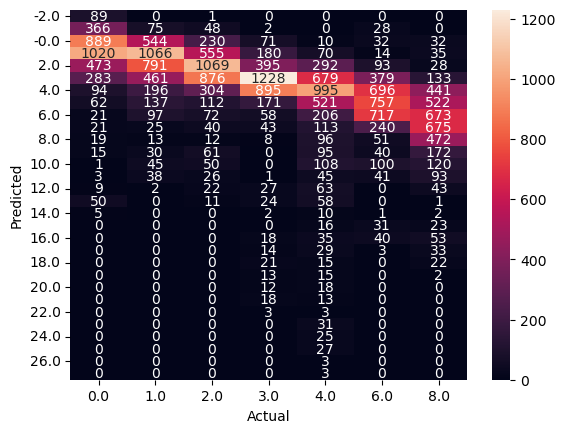

Confusion Matrix:
 None


In [27]:
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df_transformed_filtered, label, cv=cv)
# Step 7: Compute the confusion matrix
confusion_mat = confusion_matrix(label, np.round(y_pred))

# Step 8: View the confusion matrix
print("Confusion Matrix:\n", confusion_mat)

50


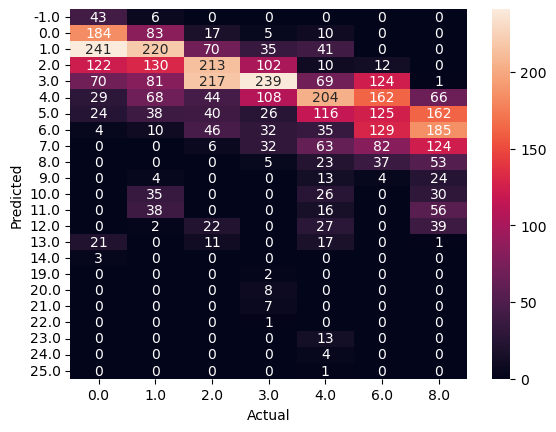

100


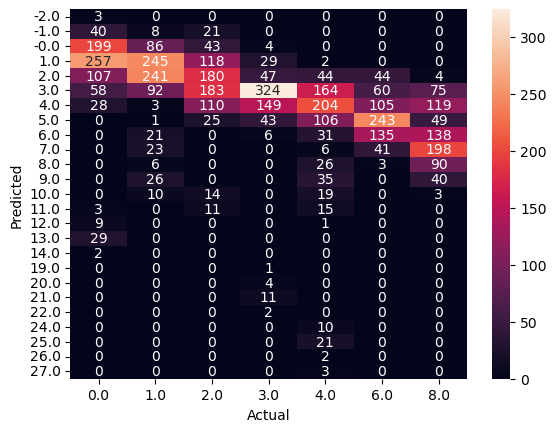

200


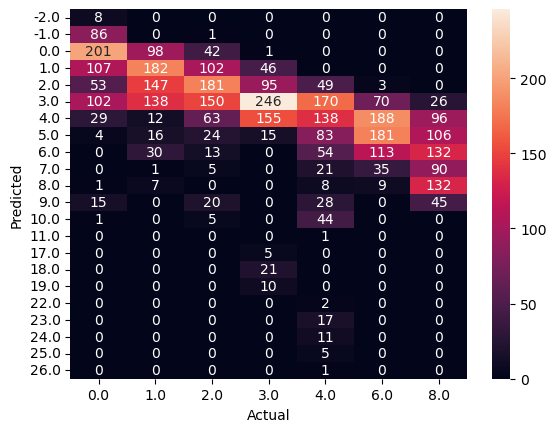

300


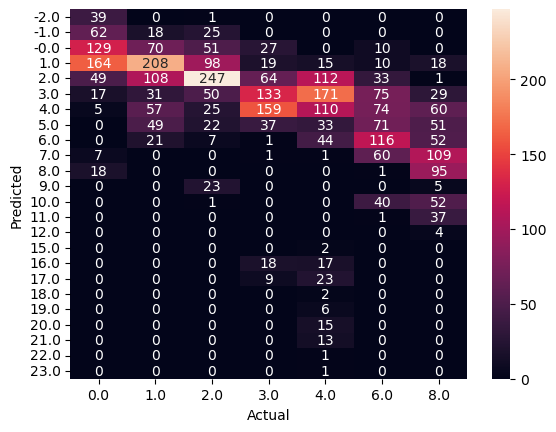

400


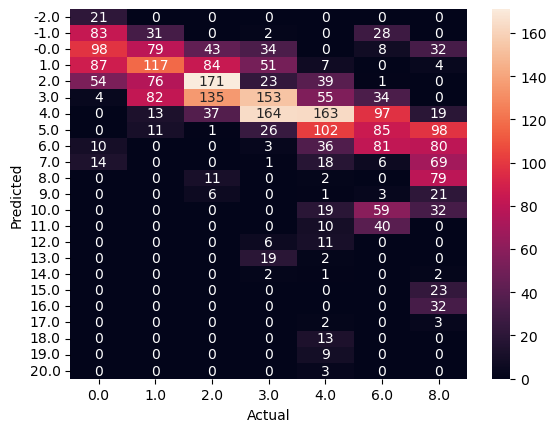

500


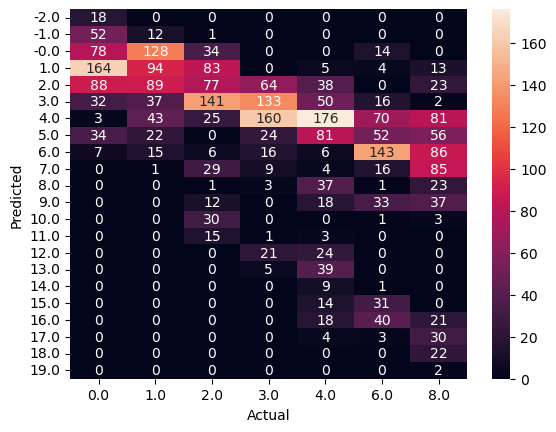

In [30]:
for i in [50,100,200,300,400,500]:
    print(i)
    new_array1 = label[(torque == i)]
    new_array2 = np.round(y_pred)[(torque == i)]
    confusion_mat = confusion_matrix(new_array1, new_array2)

100


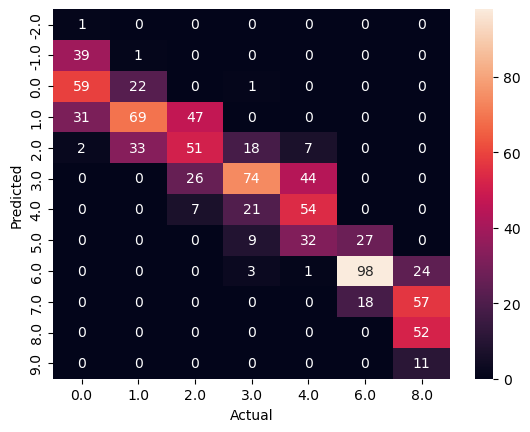

200


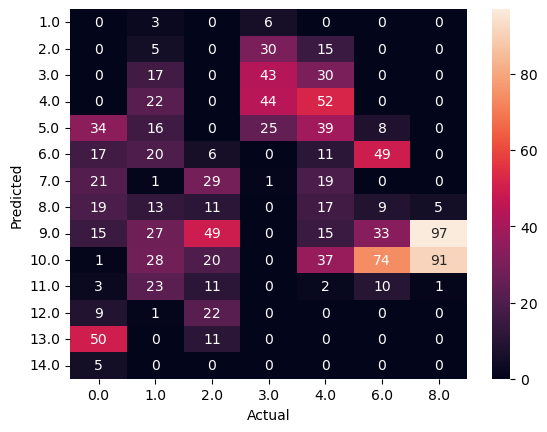

300


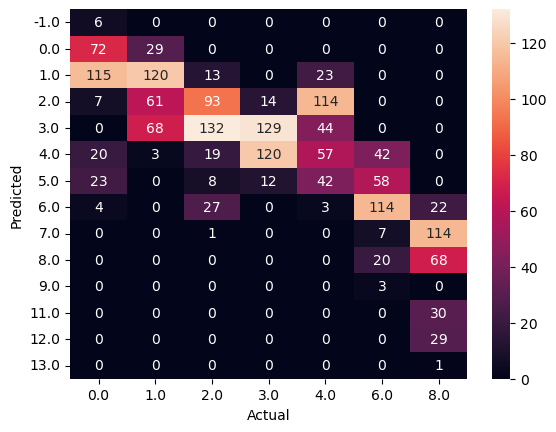

400


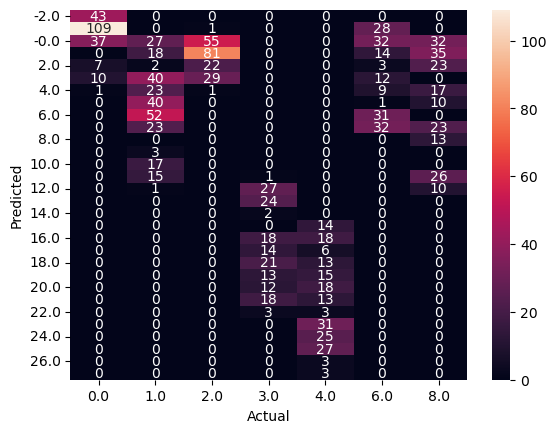

500


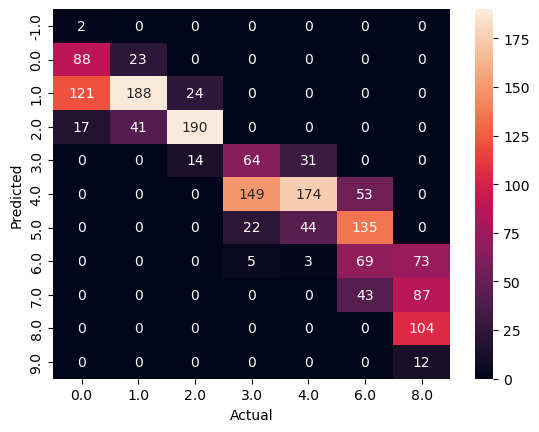

600


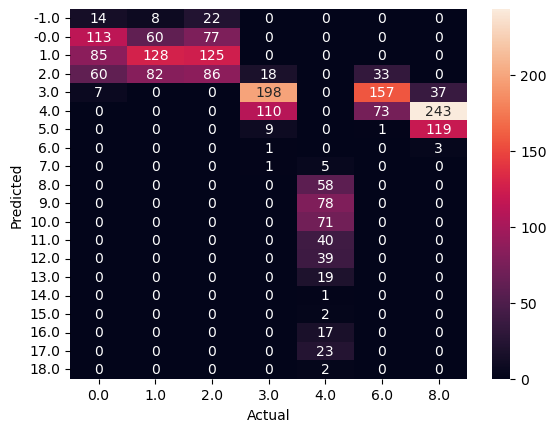

700


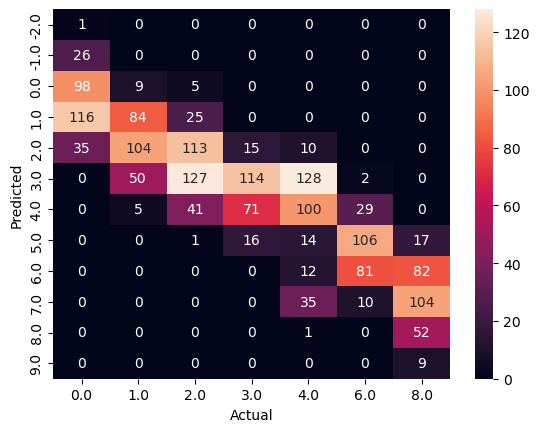

800


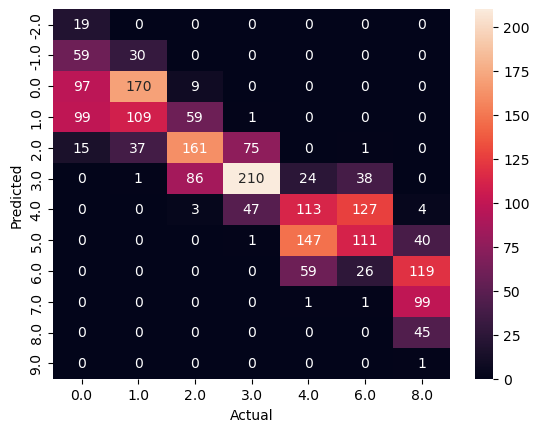

900


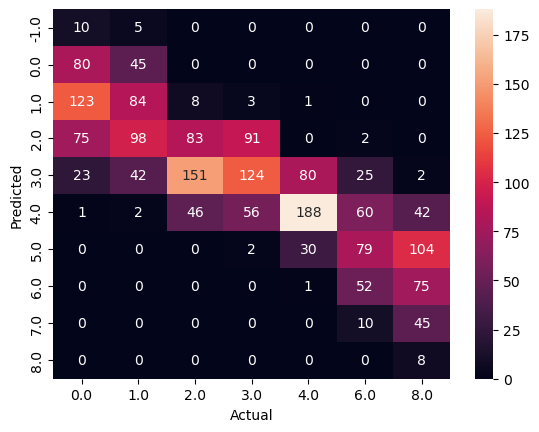

1000


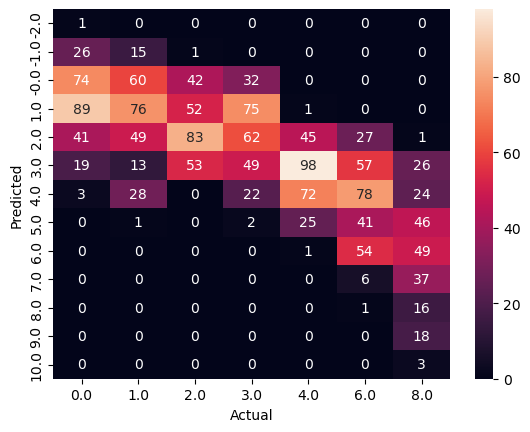

1200


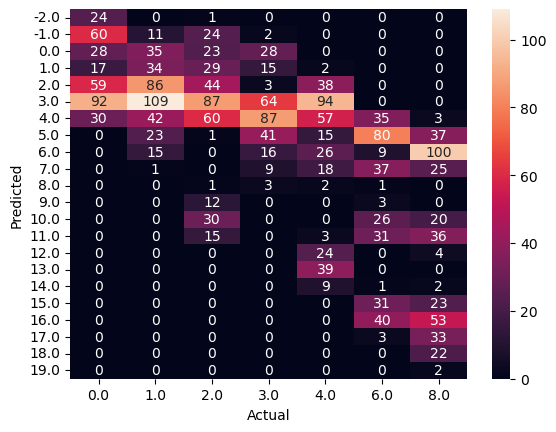

2100


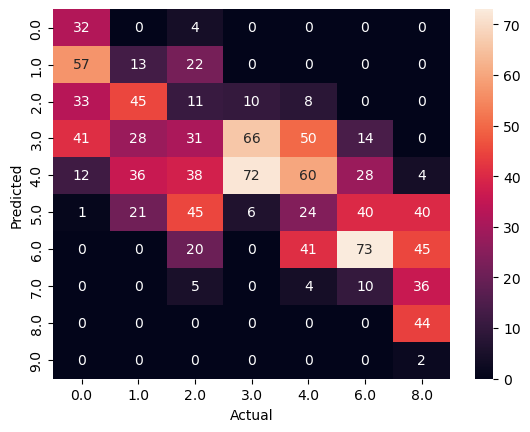

2700


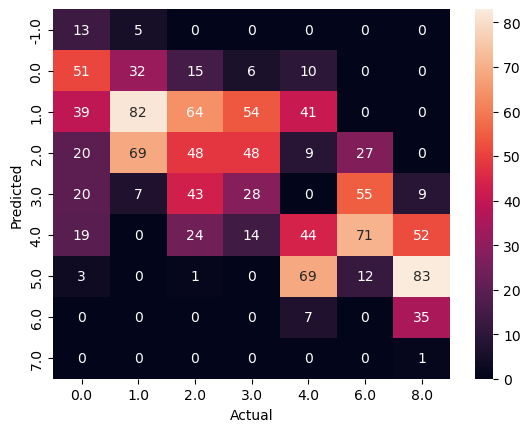

3000


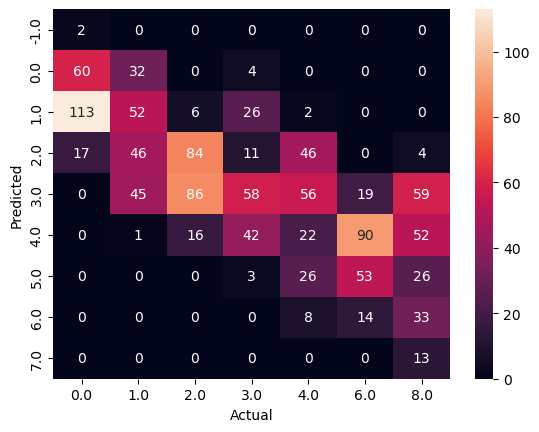

3600


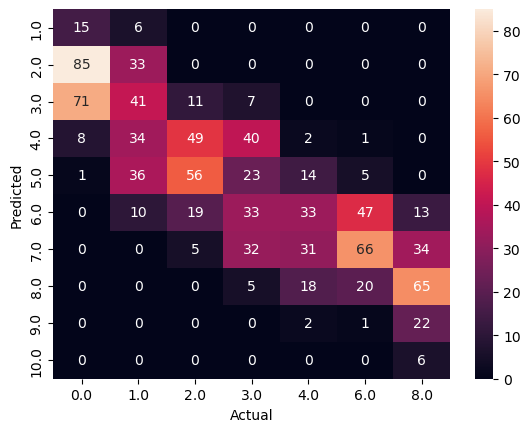

In [29]:
for i in [100,200,300,400,500,600,700,800,900,1000,1200,2100,2700,3000,3600]:
    print(i)
    new_array1 = label[(speed == i)]
    new_array2 = np.round(y_pred)[(speed == i)]
    confusion_mat = confusion_matrix(new_array1, new_array2)

In [ ]:
import numpy as np
from scipy.stats import mode

y = np.array([8, 8, 8, 8, 2, 2, 2, 2, 5, 5, 1, 1, 1, 6, 6])
y_pred = np.array([4, 3, 2, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
index = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4])

unique_indices = np.unique(index)

unique_y = []
pred_values = []

for idx in unique_indices:
    idx_values = y[index == idx]
    pred_values_idx = y_pred[index == idx]
    mode_value = mode(pred_values_idx).mode

    if len(mode_value) > 1:
        avg_value = np.mean(pred_values_idx)
        pred_values.append(avg_value)
    else:
        pred_values.append(mode_value[0])

    unique_y.append(np.unique(idx_values)[0])

print(unique_y)
print(pred_values)

# Only additional features

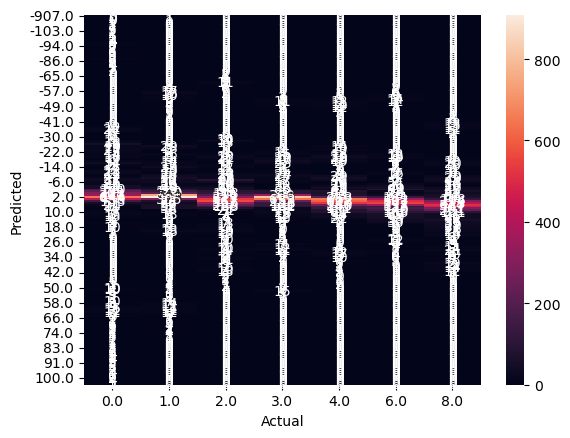

Confusion Matrix:
 None


In [11]:
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df_add, label, cv=cv)
# Step 7: Compute the confusion matrix
confusion_mat = confusion_matrix(label, np.round(y_pred))

# Step 8: View the confusion matrix
print("Confusion Matrix:\n", confusion_mat)

# Test single condition

## V=200

In [32]:
new_array1 = label[(speed == 200)]
new_array2 = df[speed == 200]

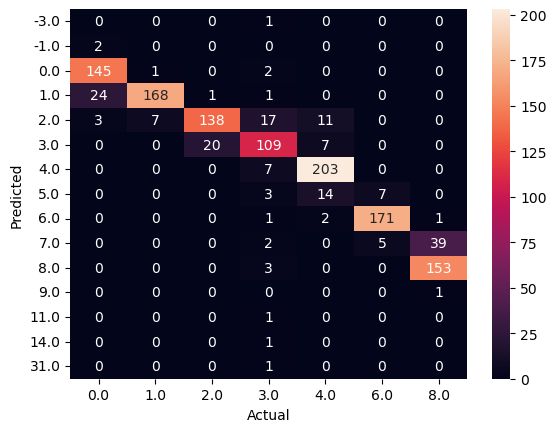

Confusion Matrix:
 None


In [36]:
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, new_array2, new_array1, cv=cv)
# Step 7: Compute the confusion matrix
confusion_mat = confusion_matrix(new_array1, np.round(y_pred))

# Step 8: View the confusion matrix
print("Confusion Matrix:\n", confusion_mat)

In [11]:
new_array1 = label[(speed == 200)]
new_array2 = df_all[speed == 200]

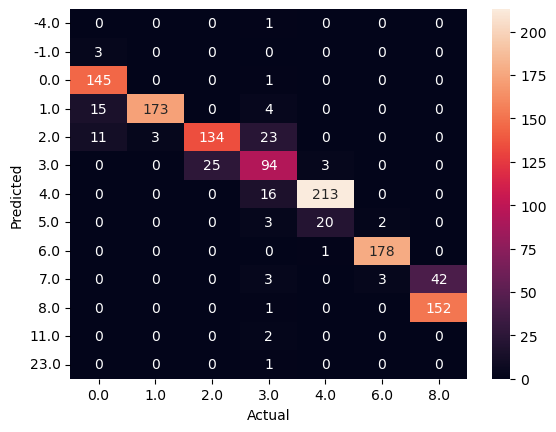

Confusion Matrix:
 None


In [38]:
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, new_array2, new_array1, cv=cv)
# Step 7: Compute the confusion matrix
confusion_mat = confusion_matrix(new_array1, np.round(y_pred))

# Step 8: View the confusion matrix
print("Confusion Matrix:\n", confusion_mat)

# Pytorch 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the linear regression model
class LinearRegression_scaled(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression_scaled, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        linear_output = self.linear(x)
        sigmoid_output = self.sigmoid(linear_output)
        scaled_output = 10.0 * sigmoid_output
        return scaled_output

# Define the input and target data
input_data = torch.tensor(new_array2.values)
target_data = torch.tensor(new_array1.values)

# Define the model
model = LinearRegression_scaled(input_size=1, output_size=1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(input_data)
    loss = criterion(outputs, target_data)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model
test_input = torch.tensor([[5.0]])
predicted_output = model(test_input)
print(f'Predicted output: {predicted_output.item():.4f}')

In [43]:
new_array2.shape

(1272, 10460)

In [48]:
scaler = StandardScaler(with_mean =False)
new_array2=scaler.fit_transform(new_array2)

In [127]:
new_array2_scaled[:10,:4]

array([[-1.59868317,  1.61654958, -1.57187264,  0.77737146],
       [-1.55677805,  1.62402464, -1.57884295,  0.84775988],
       [-1.61743009,  1.61991341, -1.56664492,  0.53655473],
       [-1.63121442,  1.61991341, -1.56211422,  0.83294243],
       [-1.57828192,  1.59487234, -1.55828053,  0.85517413],
       [-1.60144012,  1.60645863, -1.56315975,  0.47727388],
       [-1.56670281,  1.58777098, -1.53771814,  0.50320994],
       [-1.44925912,  1.51675955, -1.51611018,  0.31426533],
       [-1.40514836,  1.44014098, -1.48962303,  0.73661794],
       [-1.23091219,  1.35679586, -1.45268038,  0.71068188]])

In [119]:
new_array1=np.array([[1.0], [2.0], [3.0], [4.0], [1.0], [2.0], [3.0], [4.0], [2.0], [3.0]])

In [113]:
new_array2[:10,:4]

array([[0.27963999, 0.91343999, 0.02032   , 0.53820002],
       [0.28268   , 0.91424   , 0.01952   , 0.53895998],
       [0.27827999, 0.9138    , 0.02092   , 0.53560001],
       [0.27728   , 0.9138    , 0.02144   , 0.5388    ],
       [0.28112   , 0.91112   , 0.02188   , 0.53904003],
       [0.27943999, 0.91236001, 0.02132   , 0.53495997],
       [0.28196001, 0.91035998, 0.02424   , 0.53523999],
       [0.29047999, 0.90276003, 0.02672   , 0.53320003],
       [0.29368001, 0.89455998, 0.02976   , 0.53776002],
       [0.30632001, 0.88564003, 0.034     , 0.53748   ]])

In [116]:
scaler = StandardScaler()
new_array2_scaled=scaler.fit_transform(new_array2[:10,:4])

In [13]:
from torch.optim import LBFGS

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import LBFGS

scaler = StandardScaler()

new_array2_scaled=scaler.fit_transform(new_array2)
scaler2 = StandardScaler()
new_array1_scaled=scaler2.fit_transform(np.array(new_array1).reshape(-1,1))
# Define the linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Define the input and target data
input_data = torch.tensor(new_array2_scaled, dtype=torch.float32)
print(input_data)
target_data = torch.tensor(np.array(new_array1).reshape(-1,1), dtype=torch.float32)
if torch.isnan(input_data).any():
    print("Input data contains NaN values.")

# Check for NaN values in target_data
if torch.isnan(target_data).any():
    print("Target data contains NaN values.")
# Define the model
model = LinearRegression(input_size=10460, output_size=1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = LBFGS(model.parameters(), lr=0.1)

# Train the model
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(input_data)
    loss = criterion(outputs, target_data)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step(closure)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model

predicted_output = model(input_data)


tensor([[-1.5987,  1.6165, -1.5719,  ..., -0.3993, -0.3316, -0.2633],
        [-1.5568,  1.6240, -1.5788,  ..., -0.3993, -0.3316, -0.2633],
        [-1.6174,  1.6199, -1.5666,  ..., -0.3993, -0.3316, -0.2633],
        ...,
        [-2.3260,  2.0071, -1.7040,  ...,  0.9337, -0.3316, -0.2633],
        [-2.3397,  2.0337, -1.6984,  ...,  2.9332,  0.9052,  2.0463],
        [-2.3938,  2.0280, -1.6925,  ...,  3.5997,  3.3788,  2.0463]])


NameError: name 'closure' is not defined

In [57]:
new_array1.values.reshape([-1,1])

array([[0.],
       [0.],
       [0.],
       ...,
       [8.],
       [8.],
       [8.]])

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Define the input and target data
input_data = torch.tensor([[1.0], [2.0], [3.0], [4.0]])
target_data = torch.tensor([[2.0], [4.0], [6.0], [8.0]])

# Define the model
model = LinearRegression(input_size=1, output_size=1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(input_data)
    loss = criterion(outputs, target_data)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model
test_input = torch.tensor([[5.0]])
predicted_output = model(test_input)
print(f'Predicted output: {predicted_output.item():.4f}')

Epoch [100/1000], Loss: nan
Epoch [200/1000], Loss: nan
Epoch [300/1000], Loss: nan
Epoch [400/1000], Loss: nan
Epoch [500/1000], Loss: nan
Epoch [600/1000], Loss: nan
Epoch [700/1000], Loss: nan
Epoch [800/1000], Loss: nan
Epoch [900/1000], Loss: nan
Epoch [1000/1000], Loss: nan


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 10x1)

# Single split

In [12]:
data_path = f"C:\PHM_2023_Datadump\solo\Minirocket_1024\V100_"
dataframes=[]
for file_name in os.listdir(data_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_path, file_name)
        
        with open(file_path, "r") as file:
            content = file.read()
        
        df = pd.read_csv(file_path)
        dataframes.append(df)
df = np.concatenate(dataframes)

In [13]:
df = pd.DataFrame(df)
label = df[9998]
speed = df[9996]
torque = df[9997]
df.drop(columns=[9996, 9998], inplace=True)

In [8]:
data_path = f"C:\PHM_2023_Datadump/solo/train_additional/V100_"
dataframes=[]
for file_name in os.listdir(data_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_path, file_name)
        
        with open(file_path, "r") as file:
            content = file.read()
        
        df_tmp = pd.read_csv(file_path)
        dataframes.append(df_tmp)
df_add = np.concatenate(dataframes)

In [14]:
df_all = np.concatenate([df, df_add],axis=1)

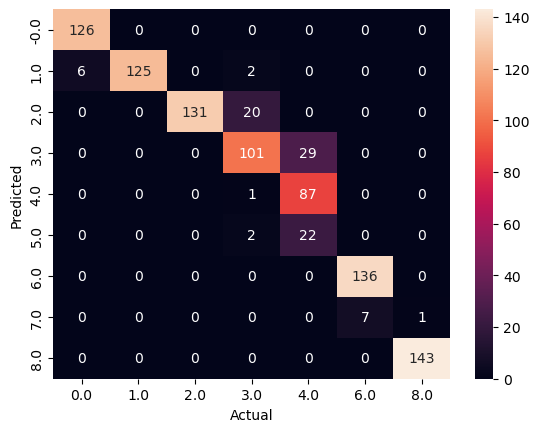

Confusion Matrix:
 None


In [18]:
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df_all, label, cv=cv)
# Step 7: Compute the confusion matrix
confusion_mat = confusion_matrix(label, np.round(y_pred))

# Step 8: View the confusion matrix
print("Confusion Matrix:\n", confusion_mat)

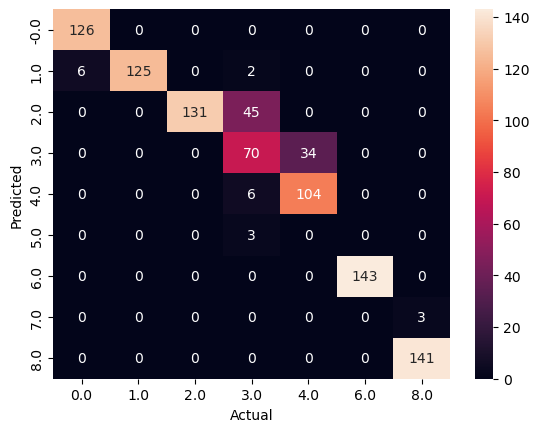

Confusion Matrix:
 None


In [17]:
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df, label, cv=cv)
# Step 7: Compute the confusion matrix
confusion_mat = confusion_matrix(label, np.round(y_pred))

# Step 8: View the confusion matrix
print("Confusion Matrix:\n", confusion_mat)

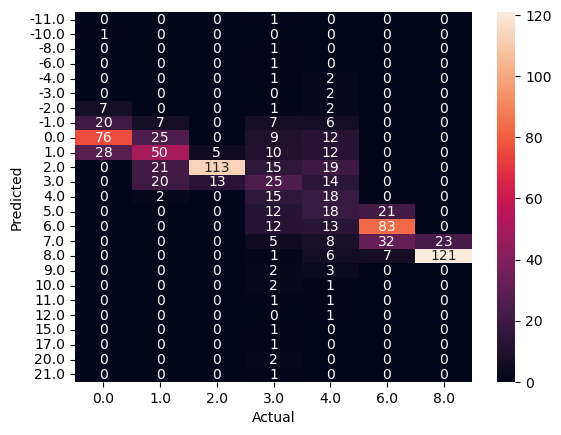

Confusion Matrix:
 None


In [19]:
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(multivar_rocket, df_add, label, cv=cv)
# Step 7: Compute the confusion matrix
confusion_mat = confusion_matrix(label, np.round(y_pred))

# Step 8: View the confusion matrix
print("Confusion Matrix:\n", confusion_mat)